# Phoneme Recognition
The data were extracted from the TIMIT database (TIMIT Acoustic-Phonetic Continuous Speech Corpus, NTIS, US Dept of Commerce) which is a widely used resource for research in speech recognition. A dataset was formed by selecting five phonemes for
classification based on digitized speech from this database.  The phonemes are transcribed as follows: "sh" as in "she", "dcl" as in "dark", "iy" as the vowel in "she", "aa" as the vowel in "dark", and "ao" as the first vowel in "water".  From continuous speech of 50 male speakers, 4509 speech frames of 32 msec duration were selected, approximately 2 examples of each phoneme from each speaker.  Each speech frame is represented by 512 samples at a 16kHz sampling rate, and each frame represents one of the above five phonemes. The breakdown of the 4509 speech frames into phoneme frequencies is as follows:

|aa  |ao   |dcl |iy   |sh  |
|----|-----|----|-----|----|
|695 |1022 |757 |1163 |872 |

From each speech frame, we computed a log-periodogram, which is one of several widely used methods for casting speech data in a form suitable for speech recognition. Thus the data used in what follows consist of 4509 log-periodograms of length 256, with known class (phoneme) memberships. 

Variables:

|         |                                                       |
|---------|-------------------------------------------------------|
|x.1-x.256|log-periodogram of length 256                          |
|g        |phoneme                                                |
|speaker  |the speaker's identifier                               |

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# set common plots properties
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
# define commonly used colors
GRAY4 = '#646369'

## Load and Prepare Data

In [2]:
df = pd.read_csv("../data/Phoneme Recognition.txt")
df.head()

,row.names,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,...,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256,g,speaker
0,1,9.85770,9.20711,9.81689,9.01692,9.05675,8.92518,11.28308,11.52980,10.79713,...,12.68076,11.20767,13.69394,13.72055,12.16628,12.92489,12.51195,9.75527,sh,train.dr1.mcpm0.sa1
1,2,13.23079,14.19189,15.34428,18.11737,19.53875,18.32726,17.34169,17.16861,19.63557,...,8.45714,8.77266,9.59717,8.45336,7.57730,5.38504,9.43063,8.59328,iy,train.dr1.mcpm0.sa1
2,3,10.81889,9.07615,9.77940,12.20135,12.59005,10.53364,8.54693,9.46049,11.96755,...,5.00824,5.51019,5.95725,7.04992,7.02469,6.58416,6.27058,3.85042,dcl,train.dr1.mcpm0.sa1
3,4,10.53679,9.12147,10.84621,13.92331,13.52476,10.27831,8.97459,11.57109,12.35839,...,5.85688,5.40324,6.07126,5.30651,4.27412,3.63384,3.22823,4.63123,dcl,train.dr1.mcpm0.sa1
4,5,12.96705,13.69454,14.91182,18.22292,18.45390,17.25760,17.79614,17.76387,18.99632,...,8.00151,7.58624,6.65202,7.69109,6.93683,7.03600,7.01278,8.52197,aa,train.dr1.mcpm0.sa1


In [3]:
# PAGE 148. The goal is to use such data to classify a spoken phoneme. These
#           two phonemes were chosen because they are difficult to separate.
df = df[(df.g == 'aa') | (df.g == 'ao')]
df.g = pd.get_dummies(df.g)['ao']
target = 'g'
features = [f'x.{i+1}' for i in range(256)]
X, y = df[features].values, df[target].values

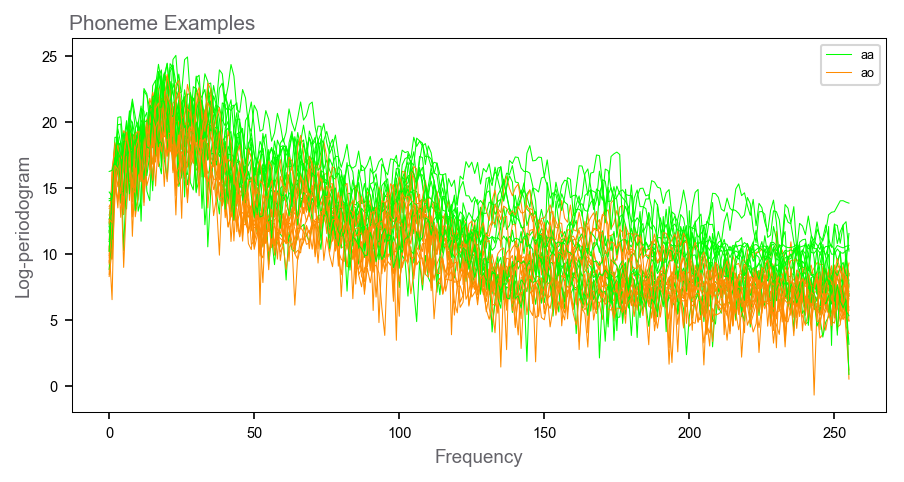

In [4]:
# PAGE 148. In the top panel of Figure 5.5 are displayed a sample of 15
#           log-periodograms for each of the two phonemes “aa” and “ao”
#           measured at 256 frequencies.
aa_first_15 = X[y == 0][:15]
ao_first_15 = X[y == 1][:15]

fig, ax = plt.subplots(figsize=(7, 3.3), dpi=150)
aa_label = {'label': 'aa'}
ao_label = {'label': 'ao'}
x_vals = range(256)
for i in range(15):
    ax.plot(x_vals, aa_first_15[i], linewidth=0.5, color='#00FF00', **aa_label)
    ax.plot(x_vals, ao_first_15[i], linewidth=0.5, color='#FF8C00', **ao_label)
    aa_label, ao_label = {}, {}
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.set_xlabel('Frequency', color=GRAY4, fontsize=9)
ax.set_ylabel('Log-periodogram', color=GRAY4, fontsize=9)
ax.legend(loc='upper right', prop={'size': 6})
_ = ax.text(-14, 27, 'Phoneme Examples', color=GRAY4, fontsize=10)

## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split
# data is split in a stratified fashion
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=1000, random_state=279, stratify=y)

## Raw Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [7]:
# LogisticRegression is regularized version, we put high value to C to minimize
# regularization
lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=1e43, tol=1e-100)
lr.fit(X_train, y_train)
lr_coef = np.squeeze(lr.coef_)
lr_training_error = 1 - accuracy_score(y_train, lr.predict(X_train))
lr_test_error = 1 - accuracy_score(y_test, lr.predict(X_test))
print(f'Training error: {lr_training_error:.3f}')
print(f'    Test error: {lr_test_error:.3f}')

Training error: 0.080
    Test error: 0.255


## Restricted Logistic Regression

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [9]:
# PAGE 148. In this example we use splines to reduce flexibility rather than
#           increase it; the application comes under the general heading of
#           functional modeling.

# sklearn doesn't have natural cubic spline basis expansion so, let's implement
# it with fit-transform method to be used in a pipeline
class NaturalCubicSplineFeatures():
    # you can specify knots locations or degrees of freedom
    def __init__(self, knots=None, df=None):
        self.knots = knots
        self.df = df

    @staticmethod
    def dk(x, xi_k, xi_K):
        return (max(0, x-xi_k)**3) / (xi_K-xi_k)

    @staticmethod
    def do_nc_expansion(x, xis):
        X = np.zeros(shape=(x.shape[0], len(xis)-1))
        for i in range(X.shape[0]):
            X[i, 0] = x[i]
            for k in range(2, len(xis)):
                dk1 = NaturalCubicSplineFeatures.dk(x[i], xis[k-2], xis[-1])
                dk2 = NaturalCubicSplineFeatures.dk(x[i], xis[-2], xis[-1])
                X[i, k-1] = dk1 - dk2
        return X

    def fit(self, X, y=None):
        if self.df is not None:
            quantiles = np.linspace(0, 1, self.df+1)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:, i], quantiles)))
        # calculate the number of parameters in each component term
        self.dofs_ = np.array([len(k)-1 for k in self.knots])
        pts = [0] + list(np.cumsum(self.dofs_))
        self.pos_ = [(pts[i-1], pts[i]-1) for i in range(1, len(pts))]
        return self

    def transform(self, X):
        h = [np.ones((X.shape[0], 1))]
        for i in range(X.shape[1]):
            h.append(NaturalCubicSplineFeatures.do_nc_expansion(
                X[:, i], self.knots[i]))
        result = np.hstack(h)
        return result

In [10]:
nc = NaturalCubicSplineFeatures(df=12)
f = np.linspace(1, 256, 256).reshape((256, 1))
H = nc.fit(f).transform(f)
filter_ = FunctionTransformer(lambda X: (H.T @ X.T).T, validate=True)
# be carefull with sklearn LogisticRegression implementation it is a
# regularized version, so there are many probles with optimization better to
# use statsmodels.api, but it cannot be used as part of standard Pipeline
lr = LogisticRegression(
    solver='liblinear', max_iter=10000000, C=1e42, tol=1e-100)
flr = Pipeline([('filter', filter_),
                ('logistic', lr)])
flr.fit(X_train, y_train)
flr_training_error = 1 - accuracy_score(y_train, flr.predict(X_train))
flr_test_error = 1 - accuracy_score(y_test, flr.predict(X_test))
print(f'Training error: {flr_training_error:.3f}')
print(f'    Test error: {flr_test_error:.3f}')

Training error: 0.174
    Test error: 0.170


In [11]:
lr_coef_filtered = H @ np.squeeze(lr.coef_)

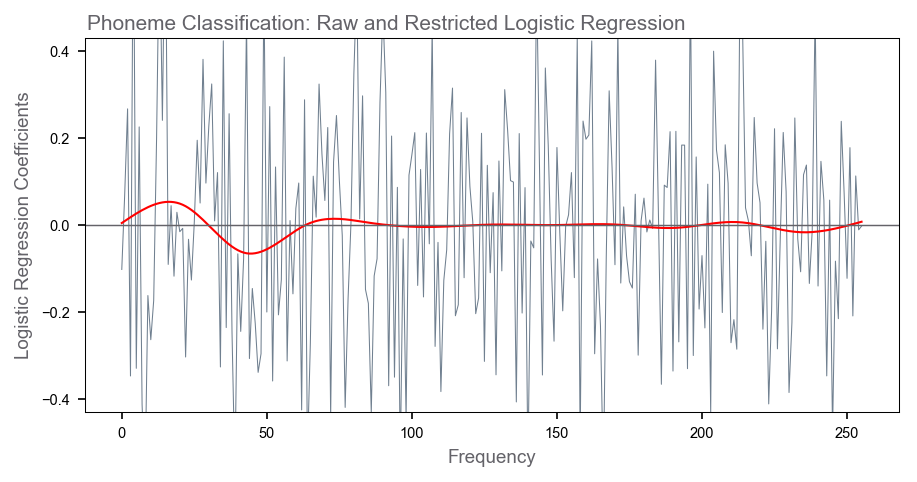

In [12]:
# PAGE 148. The gray lines in the lower panel of Figure 5.5 show the
#           coefficients of a linear logistic regression model fit by maximum
#           likelihood to a training sample of 1000 drawn from the total of 695
#           “aa”s and 1022 “ao”s. The coefficients are also plotted as a
#           function of frequency, and in fact we can think of the model in
#           terms of its continuous counterpart (5.7)
# PAGE 149. The coefficients are restricted to be smooth in the red curve, and
#           are  unrestricted in the jagged gray curve.
fig, ax = plt.subplots(figsize=(7, 3.3), dpi=150)
ax.plot(range(256), lr_coef, linewidth=0.5, color='#708090')
ax.plot(range(256), lr_coef_filtered, linewidth=1, color='red')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.set_xlabel('Frequency', color=GRAY4, fontsize=9)
ax.set_ylabel('Logistic Regression Coefficients', color=GRAY4, fontsize=9)
ax.set_ylim(-0.43, 0.43)
ax.axhline(y=0, c=GRAY4, linewidth=0.7)
_ = ax.text(-12, 0.45,
            'Phoneme Classification: Raw and Restricted Logistic Regression',
            color=GRAY4, fontsize=10)

In [13]:
# PAGE 150. Applications such as this permit a natural regularization. We force
#           the coefficients to vary smoothly as a function of frequency. The
#           red curve in the lower panel of Figure 5.5 shows such a smooth
#           coefficient curve fit to these data. We see that the lower
#           frequencies offer the most discriminatory power. Not only does the
#           smoothing allow easier interpretation of the contrast, it also
#           produces a more accurate classifier:
print('                 Raw    Regularized')
print('-----------------------------------')
print(f'Training error  {lr_training_error:.3f} {flr_training_error:>10.3f}')
print(f'    Test error  {lr_test_error:.3f} {flr_test_error:>10.3f}')

                 Raw    Regularized
-----------------------------------
Training error  0.080      0.174
    Test error  0.255      0.170
